In [ ]:
!pip install -Uqqq pip --progress-bar off
!pip install -qqq langchain-groq==0.2.0 --progress-bar off
!pip install -qqq langgraph==0.2.22 --progress-bar off

In [ ]:
import sqlite3
import textwrap
from enum import Enum, auto
from typing import List, Literal, Optional, TypedDict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from google.colab import userdata
from IPython.display import Image, display
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_groq import ChatGroq
from langgraph.graph import END, StateGraph
from pydantic import BaseModel, Field

np.random.seed(42)

MODEL = "llama-3.1-70b-versatile"

llm = ChatGroq(temperature=0, model_name=MODEL, api_key=userdata.get("GROQ_API_KEY"))

## Agent Prompts

In [ ]:
EDITOR_PROMPT = """
Rewrite for maximum social media engagement:

- Use attention-grabbing, concise language
- Inject personality and humor
- Optimize formatting (short paragraphs)
- Encourage interaction (questions, calls-to-action)
- Ensure perfect grammar and spelling
- Rewrite from first person perspective, when talking to an audience

Use only the information provided in the text. Think carefully.
"""

In [ ]:
TWITTER_PROMPT = """
Generate a high-engagement tweet from the given text:
1. What problem does this solve?
2. Focus on the main technical points/features
3. Write a short, coherent paragraph (2-3 sentences max)
4. Use natural, conversational language
5. Optimize for virality: make it intriguing, relatable, or controversial
6. Exclude emojis and hashtags
"""

In [ ]:
TWITTER_CRITIQUE_PROMPT = """
You are a Tweet Critique Agent. Your task is to analyze tweets and provide actionable feedback to make them more engaging. Focus on:

1. Clarity: Is the message clear and easy to understand?
2. Hook: Does it grab attention in the first few words?
3. Brevity: Is it concise while maintaining impact?
4. Call-to-action: Does it encourage interaction or sharing?
5. Tone: Is it appropriate for the intended audience?
6. Storytelling: Does it evoke curiosity?
7. Remove hype: Does it promise more than it delivers?

Provide 2-3 specific suggestions to improve the tweet's engagement potential.
Do not suggest hashtags. Keep your feedback concise and actionable.

Your goal is to help the writer improve their social media writing skills and increase engagement with their posts.
"""

In [ ]:
LINKEDIN_PROMPT = """
Write a compelling LinkedIn post from the given text. Structure it as follows:

1. Eye-catching headline (5-7 words)
2. Identify a key problem or challenge
3. Provide a bullet list of key benefits/features
4. Highlight a clear benefit or solution
5. Conclude with a thought-provoking question

Maintain a professional, informative tone. Avoid emojis and hashtags.
Keep the post concise (50-80 words) and relevant to the industry.
Focus on providing valuable insights or actionable takeaways that will resonate
with professionals in the field.
"""

In [ ]:
LINKEDIN_CRITIQUE_PROMPT = """
Your role is to analyze LinkedIn posts and provide actionable feedback to make them more engaging.
Focus on the following aspects:

1. Hook: Evaluate the opening line's ability to grab attention.
2. Structure: Assess the post's flow and readability.
3. Content value: Determine if the post provides useful information or insights.
4. Call-to-action: Check if there's a clear next step for readers.
5. Language: Suggest improvements in tone, style, and word choice.
6. Visual elements: Recommend additions or changes to images, videos, or formatting.

For each aspect, provide:
- A brief assessment (1-2 sentences)
- A specific suggestion for improvement
- A concise example of the suggested change

Conclude with an overall recommendation for the most impactful change the author can make to increase engagement.
Your goal is to help the writer improve their social media writing skills and increase engagement with their posts.
"""

## Graph

### State

In [ ]:
class Post(BaseModel):
    """A post written in different versions"""

    drafts: List[str]
    feedback: Optional[str]


class AppState(TypedDict):
    user_text: str
    target_audience: str
    edit_text: str
    tweet: Post
    linkedin_post: Post
    n_drafts: int

### Nodes

In [ ]:
def editor_node(state: AppState):
    prompt = f"""
text:
```
{state["user_text"]}
```
""".strip()
    response = llm.invoke([SystemMessage(EDITOR_PROMPT), HumanMessage(prompt)])
    return {"edit_text": response.content}

In [ ]:
def tweet_writer_node(state: AppState):

    post = state["tweet"]

    feedback_prompt = (
        ""
        if not post.feedback
        else f"""
Tweet:
```
{post.drafts[-1]}
```

Use the feedback to improve it:
```
{post.feedback}
```
""".strip()
    )

    prompt = f"""
text:
```
{state["edit_text"]}
```

{feedback_prompt}

Target audience: {state["target_audience"]}

Write only the text for the post
""".strip()

    response = llm.invoke([SystemMessage(TWITTER_PROMPT), HumanMessage(prompt)])
    post.drafts.append(response.content)
    return {"tweet": post}

In [ ]:
def linkedin_writer_node(state: AppState):
    post = state["linkedin_post"]

    feedback_prompt = (
        ""
        if not post.feedback
        else f"""
LinkedIn post:
```
{post.drafts[-1]}
```

Use the feedback to improve it:
```
{post.feedback}
```
""".strip()
    )

    prompt = f"""
text:
```
{state["edit_text"]}
```

{feedback_prompt}

Target audience: {state["target_audience"]}

Write only the text for the post
""".strip()

    response = llm.invoke([SystemMessage(LINKEDIN_PROMPT), HumanMessage(prompt)])
    post.drafts.append(response.content)
    return {"linkedin_post": post}

In [ ]:
def critique_tweet_node(state: AppState):
    post = state["tweet"]

    prompt = f"""
Full post:
```
{state["edit_text"]}
```

Suggested tweet (critique this):
```
{post.drafts[-1]}
```

Target audience: {state["target_audience"]}
""".strip()

    response = llm.invoke(
        [SystemMessage(TWITTER_CRITIQUE_PROMPT), HumanMessage(prompt)]
    )
    post.feedback = response.content
    return {"tweet": post}

In [ ]:
def critique_linkedin_node(state: AppState):
    post = state["linkedin_post"]

    prompt = f"""
Full post:
```
{state["edit_text"]}
```

Suggested LinkedIn post (critique this):
```
{post.drafts[-1]}
```

Target audience: {state["target_audience"]}
""".strip()

    response = llm.invoke(
        [SystemMessage(LINKEDIN_CRITIQUE_PROMPT), HumanMessage(prompt)]
    )
    post.feedback = response.content
    return {"linkedin_post": post}

In [ ]:
def supervisor_node(state: AppState):
    return state

### Edges

In [ ]:
def should_rewrite(
    state: AppState,
) -> Literal[["linkedin_critique", "tweet_critique"], END]:
    tweet = state["tweet"]
    linkedin_post = state["linkedin_post"]
    n_drafts = state["n_drafts"]
    if len(tweet.drafts) >= n_drafts and len(linkedin_post.drafts) >= n_drafts:
        return END

    return ["linkedin_critique", "tweet_critique"]

### Build a Graph

In [ ]:
graph = StateGraph(AppState)

graph.add_node("editor", editor_node)
graph.add_node("tweet_writer", tweet_writer_node)
graph.add_node("tweet_critique", critique_tweet_node)
graph.add_node("linkedin_writer", linkedin_writer_node)
graph.add_node("linkedin_critique", critique_linkedin_node)
graph.add_node("supervisor", supervisor_node)

graph.add_edge("editor", "tweet_writer")
graph.add_edge("editor", "linkedin_writer")

graph.add_edge("tweet_writer", "supervisor")
graph.add_edge("linkedin_writer", "supervisor")
graph.add_conditional_edges("supervisor", should_rewrite)

graph.add_edge("tweet_critique", "tweet_writer")
graph.add_edge("linkedin_critique", "linkedin_writer")

graph.set_entry_point("editor")

app = graph.compile()

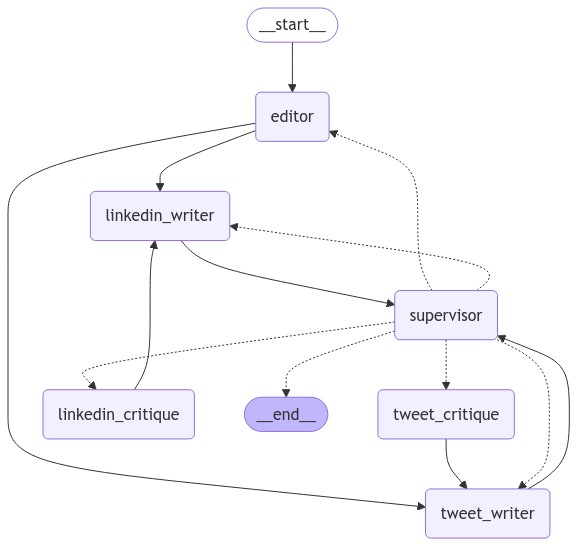

In [ ]:
display(Image(app.get_graph().draw_mermaid_png()))

## Use the Graph

In [ ]:
%%time
config = {"configurable": {"thread_id": 42}}

user_text = """
With 22 billion parameters, Mistral Small v24.09 offers customers a convenient mid-point between Mistral NeMo 12B and Mistral Large 2,
providing a cost-effective solution that can be deployed across various platforms and environments.
The new small model delivers significant improvements in human alignment, reasoning capabilities, and code over the previous model.

Mistral-Small-Instruct-2409 is an instruct fine-tuned version with the following characteristics:

- 22B parameters
- Vocabulary to 32768
- Supports function calling
- 128k sequence length

Mistral Small v24.09 is released under the MRL license. You may self-deploy it for non-commercial purposes, using e.g. vLLM

Weights on HuggingFace hub: https://huggingface.co/mistralai/Mistral-Small-Instruct-2409
"""

state = app.invoke(
    {
        "user_text": user_text,
        "target_audience": "AI/ML engineers and researchers, Data Scientists",
        "tweet": Post(drafts=[], feedback=None),
        "linkedin_post": Post(drafts=[], feedback=None),
        "n_drafts": 3,
    },
    config=config,
)

CPU times: user 225 ms, sys: 22.9 ms, total: 248 ms
Wall time: 15 s


## Post Drafts

In [ ]:
print(state["edit_text"])

Exciting News: Introducing Mistral Small v24.09

Hey everyone, I've got some awesome news to share with you all. Our team has just released Mistral Small v24.09, a game-changing model that's about to take your AI experience to the next level.

So, what makes this model so special? With 22 billion parameters, it's the perfect mid-point between our Mistral NeMo 12B and Mistral Large 2 models. This means you get a cost-effective solution that can be deployed across various platforms and environments.

But that's not all - Mistral Small v24.09 also delivers significant improvements in human alignment, reasoning capabilities, and code over our previous model. And, with our instruct fine-tuned version, Mistral-Small-Instruct-2409, you get:

 22B parameters
 A massive vocabulary of 32768
 Support for function calling
 A whopping 128k sequence length

The best part? Mistral Small v24.09 is released under the MRL license, which means you can self-deploy it for non-commercial purposes using vLLM

In [ ]:
for i, draft in enumerate(state["tweet"].drafts):
    print(f"Draft #{i+1}")
    print("-" * 10)
    print(textwrap.fill(draft, 80))
    print()

Draft #1
----------
"Introducing Mistral Small v24.09, a 22B parameter model that strikes the
perfect balance between cost-effectiveness and performance, offering significant
improvements in human alignment, reasoning capabilities, and code, with a
massive vocabulary and support for function calling."

Draft #2
----------
What if you could achieve state-of-the-art AI performance without breaking the
bank? Introducing Mistral Small v24.09, a 22B parameter model that offers
significant improvements in human alignment, reasoning capabilities, and code,
with a massive vocabulary and support for function calling - try it out and
share your experiences.

Draft #3
----------
Unlock AI performance on a budget: Introducing Mistral Small v24.09, a 22B
parameter model that delivers significant improvements in human alignment and
supports function calling - download the model on HuggingFace hub and share your
results with us.



In [ ]:
print(state["tweet"].feedback)

**Tweet Critique**

**Clarity:** 8/10 (The message is mostly clear, but some technical terms might confuse non-experts.)
**Hook:** 7/10 (The question is attention-grabbing, but it's a bit generic.)
**Brevity:** 6/10 (The tweet is a bit long and tries to pack too much information.)
**Call-to-action:** 5/10 (The CTA is vague and doesn't encourage specific interaction.)
**Tone:** 8/10 (The tone is professional and suitable for the target audience.)
**Storytelling:** 4/10 (The tweet doesn't evoke curiosity or tell a story.)
**Remove hype:** 7/10 (The tweet makes some bold claims, but they seem to be backed by technical specifications.)

**Suggestions:**

1. **Make the hook more specific**: Instead of a generic question, try to make it more specific to the benefits of Mistral Small v24.09. For example, "Unlock AI performance on a budget: Introducing Mistral Small v24.09..."
2. **Focus on one key benefit**: To make the tweet more concise, focus on one key benefit of the model, such as "Impro

In [ ]:
for i, draft in enumerate(state["linkedin_post"].drafts):
    print(f"Draft #{i+1}")
    print("-" * 10)
    print(draft)
    print()

Draft #1
----------
"Revolutionizing AI with Mistral Small v24.09"

Are you struggling to find a cost-effective AI solution that balances performance and deployment flexibility? 

Mistral Small v24.09 offers:
• 22 billion parameters for optimal performance
• Improved human alignment and reasoning capabilities
• Support for function calling and 128k sequence length
• Released under the MRL license for non-commercial self-deployment

This model provides a significant upgrade in AI capabilities while maintaining cost-effectiveness. What opportunities do you see for deploying Mistral Small v24.09 in your organization?

Draft #2
----------
"Unlocking AI Potential with Mistral Small v24.09"

Are you struggling to find a cost-effective AI solution that balances performance and deployment flexibility? 

Mistral Small v24.09 offers:
• 22 billion parameters for optimal performance
• Improved human alignment and reasoning capabilities
• Support for function calling and 128k sequence length
• Rele

In [ ]:
print(state["linkedin_post"].feedback)

**Original Post Analysis**

1. **Hook**: The opening line "Exciting News: Introducing Mistral Small v24.09" is attention-grabbing, but it could be more specific and intriguing. 
   Suggestion: Start with a question or a surprising statistic related to AI models.
   Example: "Did you know that our latest AI model can process 22 billion parameters? Introducing Mistral Small v24.09!"

2. **Structure**: The post is well-structured, but it's a bit lengthy and could be broken up with more headings or bullet points.
   Suggestion: Use clear headings to separate sections and make the post more scannable.
   Example: Use headings like "What's New in Mistral Small v24.09" and "Key Features".

3. **Content value**: The post provides useful information about the new model, but it could be more concise and focused on the benefits.
   Suggestion: Emphasize the advantages of the new model and how it can solve specific problems for the target audience.
   Example: "Mistral Small v24.09 offers improved